# ITERATIVE PRISONER'S DILEMMA 
Kosiakov Arina, Targa Pietro, Zuccolo Giada


## Description of the problem

The [Prisoner's Dilemma](https://en.wikipedia.org/wiki/Prisoner%27s_dilemma) (PD) is a classical game analyzed in game theory, which is widely used to (attempt to) model social/economical interaction. It's a "dilemma" as, if exploited to explain the emergence of altruism in human or in general animal society, it fails badly at a first glance.

The classical situation-representation of the PD is that of two prisoners whose conviction depends on their mutual cooperation. It is easier understood though if illustrated in terms of a trade-off game (closed bag exachange):

*Two people meet and exchange closed bags, with the understanding that one of them contains money, and the other contains a purchase. Either player can choose to honor the deal by putting into his or her bag what he or she agreed, or he or she can defect by handing over an empty bag.*

It is obvious that for both players the winning strategy is to NOT cooperate.

Things changes when the interaction between the two individuals is iterated, in that case a more altruist attitude (strategy) is expected to emerge. The goal of this project is to test this hypothesis.

Mathematically the PD can be expressed with very basic linear algebra. The key component is the **Payoff matrix** $M$, which quantify the reward each player gets depending on whether she cooperated or not (defect):

$$
M = 
\begin{pmatrix} 
R & S \\
T & P 
\end{pmatrix}
$$

with $T,R,S,P$ integers that satisfy the following conditions:

$$
T>R>P>S; \quad 2R > T+S
$$

for example $T=3$, $R=2$, $P=1$ and $S=0$, or  $T=5$, $R=3$, $P=2$, $S=0$. Each player choice (move) can be represented by one of the two axis in ${\rm I\!R}^2$, i.e. $u_C=\begin{pmatrix} 1 \\ 0 \end{pmatrix}$ or $u_D=\begin{pmatrix} 0 \\ 1 \end{pmatrix}$, where the first coordinate stands for *Cooperate* and the second for *Defect*. Being $u_1$ and $u_2$ their rewards $r_1$ and $r_2$ can be computed then as:

$$
r_1 = u_1^T M u_2
\quad
\quad
r_2 = u_2^T M u_1
$$

The aim of the project is to analyse the different behaviour of the prisoners in a simple tournament and in a more complex tournament, which can be seen as a natural selection between different genes.

## Definition of the strategies

In the Prisoner's Dilemma different strategies can be adopted. In this project five different strategies were taken into the analysis: 

* **Nice guy**: always cooperate
* **Bad guy**: always defect 
* **Mainly nice**: randomly defect $(100-k)\%$ of the times and cooperate $k\%$, with $k>50\%$
* **Mainly bad**: randomly defect $k\%$ of the times and cooperate $(100-k)\%$, with $k>50\%$
* **tit-for-tat**: start by cooperating, then repeat what the opponent has done in the previous move 

These strategies represent the *gene* of the prisoner and will be later used to analyse the behaviour of the different *populations*.

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement

In [137]:
#Definition of the different strategies, also referred to as genes

def nicePlayer(k,n):
    return np.array([[1,0] for i in range(n)])  


def badPlayer(k,n):
    return np.array([[0,1] for i in range(n)]) 


def mainlyNicePlayer(k,n):                                           
    def fun():
        if (np.random.choice(['Nice','Bad'], p=[k, 1-k])=='Nice'):
            return np.array([1,0])
        else:
            return np.array([0,1])

    return np.array([fun() for i in range(n)])


def mainlyBadPlayer(k,n):
    def fun():
        if(np.random.choice(['Nice','Bad'], p=[1-k, k])=='Bad'):
            return np.array([0,1])
        else:
            return np.array([1,0])

    return np.array([fun() for i in range(n)])
    
    
# TFT player returns an empty array, because it is going to be populated with past 
# moves of the opponent player/prisoner
def tftPlayer(k,n):   
    return np.array([]) 
    

## Definition of the **Prisoner()** class
A **Prisoner()** class is created in order to track the evolution of the prisoners' behaviour. This class describes a single prisoner and presents different methods to set and obtain the information about the gene and payoff. The payoff is the score of a single prisoner after a certain amount of matches.

In [138]:
class Prisoner():

    payoff = 0        # store, the total payoff after n matches
    gene = ''         # one of the strategies previously described 
    k = 0             # k parameter used to compute the probability of the "mainly" players

    def __init__(self, x, k): #initiate the prisoners, assigning the gene and the k factor
        self.gene = x
        self.k = k

    def getGene(self):
        return self.gene

    def setGene(self, g):
        self.gene = g

    def moves(self,n):                  # calls the gene function to generate an array of n moves
        return self.gene(self.k,n)
    
    def addPayoff(self,x):
        self.payoff += x

    def setPayoff(self,x):              # sets payoff to a new value
        self.payoff = x
    
    def getPayoff(self):
        return self.payoff

## Simple IPD
In this section is presented the code used to perform the simple iterated Prisoner's Dilemma (IPD). The idea is to create a match between two prisoners of *n* rounds and to analyse the performance of the different strategies. In particular, the attention is focused on three cases:
* **Nice guy** vs **Bad guy**
* **Mainly nice** vs **Tit-for-tat**
* **Mainly bad** vs **Tit-for-tat**


The compute function will be useful also in the following sections.

In [139]:
def compute(player1,player2,M,n, verbose = False, get_pays= False):     # generates n moves for the two players and computes their payoffs
        
        p1 = player1.moves(n)
        p2 = player2.moves(n)

        if (not p1.any() and not p2.any()):                # checks if one or both player are tft, and generate their moves
            p1 = np.array([[1,0] for i in range(n)])
            p2 = p1
        elif not p1.any():
            p1 = np.concatenate((np.array([[1,0]]),p2[:-1,:]))
        elif not p2.any():
            p2 = np.concatenate((np.array([[1,0]]),p1[:-1,:]))

        if get_pays:                                        # saves the payoffs of each player as an array to return them if get_pays is set True
            pays1 = []
            pays2 = []

        for i in range(n):                                  # computes the actual payoffs for each round
            pay1 = np.dot(p1[i,:], np.dot(M, np.transpose(p2[i,:])))
            pay2 = np.dot(p2[i,:], np.dot(M, np.transpose(p1[i,:])))

            if get_pays:
                pays1.append(pay1)
                pays2.append(pay2)

            if verbose: print('Round', i, 'moves:', p1[i,:], p2[i,:], 'pays', pay1,pay2)  # if True prints what happens each round

            player1.addPayoff(pay1)
            player2.addPayoff(pay2)

        if get_pays: return np.array(pays1), np.array(pays2)


The code presented below is a test simulation. The number of matches is set to 15, $k$ is set to $0.75$ and the payoff matrix is defined with the following parameters: $r = 3, s = 0, t = 5, p = 2$.
 The payoff matrix and the number of matches are going to be constant in the whole analysis. For this reason they are initialized in this section.

In [140]:
M = [[3, 0],
    [5,2]]

k = 0.75
n = 15

genes = [nicePlayer, badPlayer, mainlyNicePlayer, mainlyBadPlayer, tftPlayer] # the functions above

nice_pl = Prisoner(genes[0],k)
bad_pl = Prisoner(genes[1],k)
m_nice_pl = Prisoner(genes[2],k)
m_bad_pl = Prisoner(genes[3],k)
tft_pl = Prisoner(genes[4],k)

In [141]:
### NICE VS BAD ###
print("##### Nice guy vs Bad guy #####")
n_vs_b = compute(nice_pl,bad_pl,M,n, verbose = True, get_pays= True)
print("Nice guy total payoff: ", nice_pl.getPayoff())
print("Bad guy total payoff: ", bad_pl.getPayoff())

##### Nice guy vs Bad guy #####
Round 0 moves: [1 0] [0 1] pays 0 5
Round 1 moves: [1 0] [0 1] pays 0 5
Round 2 moves: [1 0] [0 1] pays 0 5
Round 3 moves: [1 0] [0 1] pays 0 5
Round 4 moves: [1 0] [0 1] pays 0 5
Round 5 moves: [1 0] [0 1] pays 0 5
Round 6 moves: [1 0] [0 1] pays 0 5
Round 7 moves: [1 0] [0 1] pays 0 5
Round 8 moves: [1 0] [0 1] pays 0 5
Round 9 moves: [1 0] [0 1] pays 0 5
Round 10 moves: [1 0] [0 1] pays 0 5
Round 11 moves: [1 0] [0 1] pays 0 5
Round 12 moves: [1 0] [0 1] pays 0 5
Round 13 moves: [1 0] [0 1] pays 0 5
Round 14 moves: [1 0] [0 1] pays 0 5
Nice guy total payoff:  0
Bad guy total payoff:  75


In [142]:
### MAINLY NICE VS TFT ###
print("\n##### Mainly nice guy vs tft #####")
n_vs_b = compute(m_nice_pl,tft_pl,M,n, verbose = True, get_pays= True)
print("Mainly nice guy total payoff: ", m_nice_pl.getPayoff())
print("Tft total payoff: ", tft_pl.getPayoff())


##### Mainly nice guy vs tft #####
Round 0 moves: [1 0] [1 0] pays 3 3
Round 1 moves: [1 0] [1 0] pays 3 3
Round 2 moves: [1 0] [1 0] pays 3 3
Round 3 moves: [1 0] [1 0] pays 3 3
Round 4 moves: [1 0] [1 0] pays 3 3
Round 5 moves: [0 1] [1 0] pays 5 0
Round 6 moves: [1 0] [0 1] pays 0 5
Round 7 moves: [0 1] [1 0] pays 5 0
Round 8 moves: [1 0] [0 1] pays 0 5
Round 9 moves: [1 0] [1 0] pays 3 3
Round 10 moves: [1 0] [1 0] pays 3 3
Round 11 moves: [1 0] [1 0] pays 3 3
Round 12 moves: [1 0] [1 0] pays 3 3
Round 13 moves: [1 0] [1 0] pays 3 3
Round 14 moves: [1 0] [1 0] pays 3 3
Mainly nice guy total payoff:  43
Tft total payoff:  43


In [143]:
### MAINLY BAD VS TFT ###
print("\n##### Mainly bad guy vs tft #####")
tft_pl.setPayoff(0)
n_vs_b = compute(m_bad_pl,tft_pl,M,n, verbose = True, get_pays= True)
print("Mainly bad guy total payoff: ", m_bad_pl.getPayoff())
print("Tft total payoff: ", tft_pl.getPayoff())


##### Mainly bad guy vs tft #####
Round 0 moves: [0 1] [1 0] pays 5 0
Round 1 moves: [0 1] [0 1] pays 2 2
Round 2 moves: [1 0] [0 1] pays 0 5
Round 3 moves: [1 0] [1 0] pays 3 3
Round 4 moves: [1 0] [1 0] pays 3 3
Round 5 moves: [0 1] [1 0] pays 5 0
Round 6 moves: [0 1] [0 1] pays 2 2
Round 7 moves: [0 1] [0 1] pays 2 2
Round 8 moves: [1 0] [0 1] pays 0 5
Round 9 moves: [1 0] [1 0] pays 3 3
Round 10 moves: [1 0] [1 0] pays 3 3
Round 11 moves: [1 0] [1 0] pays 3 3
Round 12 moves: [0 1] [1 0] pays 5 0
Round 13 moves: [0 1] [0 1] pays 2 2
Round 14 moves: [1 0] [0 1] pays 0 5
Mainly bad guy total payoff:  38
Tft total payoff:  38


It is possible to observe that:
* in the first case the result is obious; bad guy always wins
* the tit-for-tat player starts cooperating and than copies the previous opponent's move

## Multiple players IPD (MPIPD)



In this section all the possible pairings of different types of prisoners are considered.
Then the mean payoff per round is stored inside a multi-index dataframe.




In [144]:
s = 100
def dfSetup():
    columns = ['Nice', 'Bad', 'Mainly Nice', 'Mainly Bad', 'Tit for Tat']
    tuples = list(combinations_with_replacement(columns, 2))
    multi_index = pd.MultiIndex.from_tuples(tuples, names=['PlayerA', 'PlayerB'])
    df = pd.DataFrame(pd.Series(index=multi_index))
    df = df.iloc[: , :-1]              #drops last column of NaNs
    return df

def tot_pay(player1,player2,M,s):
    res1, res2 = compute(player1,player2, M, s, get_pays=True)
    return (round(np.sum(res1)/s,2), round(np.sum(res2)/s,2))


df = dfSetup()

genes = [nicePlayer, badPlayer, mainlyNicePlayer, mainlyBadPlayer, tftPlayer]
tuples = list(combinations_with_replacement(genes, 2))

res = [tot_pay(Prisoner(x[0],k),Prisoner(x[1],k),M,s) for x in tuples]

df['Average Payoff (PlayerA, PlayerB)'] = res
df

C:\Users\pietr\AppData\Local\Temp\ipykernel_7096\2200630185.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df = pd.DataFrame(pd.Series(index=multi_index))


Average Payoff (PlayerA, PlayerB)
PlayerA     PlayerB                                      
Nice        Nice                               (3.0, 3.0)
            Bad                                (0.0, 5.0)
            Mainly Nice                      (2.28, 3.48)
            Mainly Bad                        (0.75, 4.5)
            Tit for Tat                        (3.0, 3.0)
Bad         Bad                                (2.0, 2.0)
            Mainly Nice                      (3.98, 0.68)
            Mainly Bad                       (2.78, 1.48)
            Tit for Tat                      (2.03, 1.98)
Mainly Nice Mainly Nice                      (2.77, 2.67)
            Mainly Bad                       (1.01, 3.81)
            Tit for Tat                      (2.74, 2.74)
Mainly Bad  Mainly Bad                       (2.09, 2.34)
            Tit for Tat                      (2.26, 2.21)
Tit for Tat Tit for Tat                        (3.0, 3.0)

As expected the results mirror the ones from the previous analysis.

## Repeated MPIPD
The following section presents the problem of the MPIPD.

This is the implemented approach:

* A population is defined as a set of multiple prisoners with the same gene, so implementing the same strategy.

* The different populations are initializated with an equal number of prisoners.

* Random couples are generated among all the prisoners and these couples will play for a given number of rounds. At the end of these rounds is time to change generation.

* The number of prisoners in each population of the new generation will depend on the results that each strategy achieved in the previous generation.

This process is iterated until only one population will remain 'alive'.

In [145]:
# Compute the p array, that determines the number of the members of each population in the next generation each generation has allways the same amount of total prisoners
def nextGen(nice_pop, bad_pop, m_nice_pop, m_bad_pop, tft_pop, genes, k, total):

    def getFactor(x):

        if np.any(x):
            return np.sum([x[i].getPayoff() for i in range(len(x))])
        else:
            return 0

    #p array normalized total payoffs of the considered populations
    p = np.array(list(map(getFactor, [nice_pop, bad_pop, m_nice_pop, m_bad_pop, tft_pop])))
    #print('Total payoff per gene',p)

    p = p/np.sum(p) #normalization of the p array
    return Populate(p,total, genes, k)



# Generates new populations according to the p vector
def Populate(p,total, genes, k):

    nice_pop = np.array([Prisoner(genes[0],k) for i in range(int(np.floor(p[0]*total)))])
    bad_pop = np.array([Prisoner(genes[1],k) for i in range(int(np.floor(p[1]*total)))])
    m_nice_pop = np.array([Prisoner(genes[2],k) for i in range(int(np.floor(p[2]*total)))])
    m_bad_pop = np.array([Prisoner(genes[3],k) for i in range(int(np.floor(p[3]*total)))])
    tft_pop = np.array([Prisoner(genes[4],k) for i in range(int(total-(len(nice_pop)+len(bad_pop)+len(m_nice_pop)+len(m_bad_pop))))])

    print('Current populatons: ',len(nice_pop),len(bad_pop),len(m_nice_pop),len(m_bad_pop),len(tft_pop))

    return nice_pop, bad_pop, m_nice_pop, m_bad_pop, tft_pop


# Starts the game process  
def Start(nice_pop, bad_pop, m_nice_pop, m_bad_pop, tft_pop,M,max_gen,n_matches,genes,k,total):

    nice_pop_evol = [len(nice_pop)]
    bad_pop_evol = [len(bad_pop)]
    m_nice_pop_evol = [len(m_nice_pop)]
    m_bad_pop_evol = [len(m_bad_pop)]
    tft_pop_evol = [len(tft_pop)]

    for i in range(max_gen):
        pop = np.concatenate([nice_pop, bad_pop, m_nice_pop, m_bad_pop, tft_pop])
        np.random.shuffle(pop)
        curr = np.reshape(pop,(int(len(pop)/2),2)) #random couples of prisoners

        for row in curr:
            compute(row[0], row[1],M,n_matches) #updates the payoffs of each prisoner

        #change of the generation after n_matches
        nice_pop, bad_pop, m_nice_pop, m_bad_pop, tft_pop = nextGen(nice_pop, bad_pop, m_nice_pop, m_bad_pop, tft_pop,genes,k,total)
        nice_pop_evol.append(len(nice_pop))
        bad_pop_evol.append(len(bad_pop))
        m_nice_pop_evol.append(len(m_nice_pop))
        m_bad_pop_evol.append(len(m_bad_pop))
        tft_pop_evol.append(len(tft_pop))
        
        #Breaks if only one population remains
        if (len(nice_pop)==total or len(bad_pop)==total or len(m_nice_pop)==total or len(m_bad_pop)==total or len(tft_pop)==total): break

    return np.array(nice_pop_evol), np.array(bad_pop_evol), np.array(m_nice_pop_evol), np.array(m_bad_pop_evol), np.array(tft_pop_evol) 

### Demo of the MPIPD

Current populatons:  200 200 200 200 200
Current populatons:  139 254 171 231 205
Current populatons:  90 306 145 246 213
Current populatons:  61 353 116 249 221
Current populatons:  36 395 93 245 231
Current populatons:  18 444 61 235 242
Current populatons:  8 487 36 213 256
Current populatons:  3 512 23 192 270
Current populatons:  1 520 14 177 288
Current populatons:  0 525 9 158 308
Current populatons:  0 529 5 139 327
Current populatons:  0 524 1 120 355
Current populatons:  0 511 1 103 385
Current populatons:  0 492 0 85 423
Current populatons:  0 465 0 68 467
Current populatons:  0 426 0 60 514
Current populatons:  0 386 0 50 564
Current populatons:  0 341 0 40 619
Current populatons:  0 293 0 33 674
Current populatons:  0 246 0 27 727
Current populatons:  0 198 0 21 781
Current populatons:  0 156 0 17 827
Current populatons:  0 119 0 14 867
Current populatons:  0 89 0 10 901
Current populatons:  0 65 0 7 928
Current populatons:  0 47 0 4 949
Current populatons:  0 33 0 3 964
C

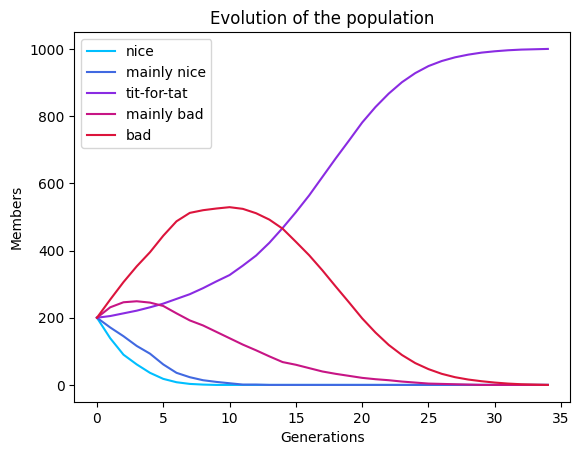

In [146]:
n_prisoners = 1000 #total number of prisoners
init = [0.2,0.2,0.2,0.2,0.2] #initialization of the p vector (see nextGen())  in this way we have equal populations at the beginning

rounds = 100
matches = 50

nice_pop, bad_pop, m_nice_pop, m_bad_pop, tft_pop = Populate(init,n_prisoners,genes,k)

nice_pop_evol, bad_pop_evol, m_nice_pop_evol, m_bad_pop_evol, tft_pop_evol = Start(nice_pop, bad_pop, m_nice_pop, m_bad_pop, tft_pop,M,rounds,matches,genes,k,n_prisoners)

fig = plt.figure()
plt.plot(np.arange(len(nice_pop_evol)),nice_pop_evol, label='nice', c = "deepskyblue")
plt.plot(np.arange(len(nice_pop_evol)),m_nice_pop_evol, label='mainly nice', c = "royalblue")
plt.plot(np.arange(len(nice_pop_evol)),tft_pop_evol, label='tit-for-tat', c = "blueviolet")
plt.plot(np.arange(len(nice_pop_evol)),m_bad_pop_evol, label='mainly bad', c = "mediumvioletred")
plt.plot(np.arange(len(nice_pop_evol)),bad_pop_evol, label='bad', c = "crimson")

plt.legend(loc='best')
plt.title('Evolution of the population')
plt.xlabel('Generations')
plt.ylabel('Members')
plt.show()

It is possible to notice that the population of the tft is the one that survives. This is an expected outcome for the following reasons:
* The population of the bad guys most likely destroys all the population of nice guys, same happens to the mainly nice population
* The mainly bad remains alive till there are the nice and mainly nice populations, but as soon as they are gone, it loses to the bad population. In fact, mainly bad guys can sometimes behave as nice, which makes them weaker with respect to the bad guys
* As soon as the nice and mainly nice guys are gone, the bad guys don't have anyone to take advantage of and their population rapidly decreases
* Tft wins because it is the only strategy that can penilize the bad guys

## rMPIPD with gene mutations

In this last section it is reported the problem of the mutating MPIPD. This problem consists in the analysis of the different populations when a random mutation occurs. The main idea is to use this random mutation in order to change the prisoner's strategy. The final aim is to observe which strategies survive and what are the differences with respect to the previous situations.

In [147]:
 # h parameter sets the probability of a prisoner to change strategy
def nextGenMutating(nice_pop, bad_pop, m_nice_pop, m_bad_pop, tft_pop, genes, k, h, total):

    def getFactor(x):
        if np.any(x):
            return np.sum([x[i].getPayoff() for i in range(len(x))])
        else:
            return 0

    p = np.array(list(map(getFactor, [nice_pop, bad_pop, m_nice_pop, m_bad_pop, tft_pop])))
    p = p/np.sum(p)
    return PopulateMutating(p,total, genes, k, h)



def PopulateMutating(p,total, genes, k, h):

    nice_pop = np.array([Prisoner(genes[0],k) for i in range(int(np.floor(p[0]*total)))])
    bad_pop = np.array([Prisoner(genes[1],k) for i in range(int(np.floor(p[1]*total)))])
    m_nice_pop = np.array([Prisoner(genes[2],k) for i in range(int(np.floor(p[2]*total)))])
    m_bad_pop = np.array([Prisoner(genes[3],k) for i in range(int(np.floor(p[3]*total)))])
    tft_pop = np.array([Prisoner(genes[4],k) for i in range(int(total-(len(nice_pop)+len(bad_pop)+len(m_nice_pop)+len(m_bad_pop))))])

    print('**** New Generation ****')
    print('Current populatons before mutation: ',len(nice_pop),len(bad_pop),len(m_nice_pop),len(m_bad_pop),len(tft_pop))

    pop = [nice_pop, bad_pop, m_nice_pop, m_bad_pop, tft_pop] #population before mutation
    
    mutating_nice = []
    mutating_bad = []
    mutating_m_nice = []
    mutating_m_bad = []
    mutating_tft = []

    idx_mutations = [mutating_nice, mutating_bad, mutating_m_nice, mutating_m_bad, mutating_tft]
    pay_mutations = []

    for l in range(len(pop)):
        for u in range(len(pop[l])):
            if (np.random.choice(['Mutate','Not Mutate'], p=[h, 1-h])=='Mutate'):
                idx_mutations[l] = np.append(idx_mutations[l],u) #saves the index of the prisoner that decided to mutate
                pay_mutations = np.append(pay_mutations, pop[l][u].getPayoff())

    #delete the prisoner that mutated from the original population
    for i in range(len(pop)):
        idxs = [int(x) for x in idx_mutations[i]] # cast to int requested by np.delete()
        pop[i] = np.delete(pop[i], idxs)


    missing_prisoners = total - (len(pop[0])+len(pop[1])+len(pop[2])+len(pop[3])+len(pop[4]))
    print('Mutated prisoners: ', missing_prisoners)
    
    mutated_genes = np.random.randint(0,5, missing_prisoners) # choose new random genes for the mutated prisoners

    #add the mutated prisoner to the right new population
    for i in range(missing_prisoners):
        new_prisoner = Prisoner(genes[mutated_genes[i]],k)
        new_prisoner.setPayoff(pay_mutations[i]) # keep track of the payoff of the mutated prisoner, so it is not set to 0
        pop[mutated_genes[i]] = np.append(pop[mutated_genes[i]], new_prisoner) 

    
    print('Current populatons after mutating: ',len(pop[0]),len(pop[1]),len(pop[2]),len(pop[3]),len(pop[4]))
    print('\n')
                
    return pop[0],pop[1],pop[2],pop[3],pop[4]



def StartMutating(nice_pop, bad_pop, m_nice_pop, m_bad_pop, tft_pop, M, rounds, matches, genes, k, h, total):

    nice_pop_evol = [len(nice_pop)]
    bad_pop_evol = [len(bad_pop)]
    m_nice_pop_evol = [len(m_nice_pop)]
    m_bad_pop_evol = [len(m_bad_pop)]
    tft_pop_evol = [len(tft_pop)]
    
    for i in range(rounds):
        pop = np.concatenate([nice_pop, bad_pop, m_nice_pop, m_bad_pop, tft_pop])
        np.random.shuffle(pop)
        curr = np.reshape(pop,(int(len(pop)/2),2))

        for row in curr:
            compute(row[0], row[1],M,matches)

        nice_pop, bad_pop, m_nice_pop, m_bad_pop, tft_pop = nextGenMutating(nice_pop, bad_pop, m_nice_pop, m_bad_pop, tft_pop, genes, k, h,total)
        nice_pop_evol.append(len(nice_pop))
        bad_pop_evol.append(len(bad_pop))
        m_nice_pop_evol.append(len(m_nice_pop))
        m_bad_pop_evol.append(len(m_bad_pop))
        tft_pop_evol.append(len(tft_pop))
        
        
        if (len(nice_pop)==total or len(bad_pop)==total or len(m_nice_pop)==total or len(m_bad_pop)==total or len(tft_pop)==total): break


    return np.array(nice_pop_evol), np.array(bad_pop_evol), np.array(m_nice_pop_evol), np.array(m_bad_pop_evol), np.array(tft_pop_evol) 


### Demo

Current populatons:  200 200 200 200 200
**** New Generation ****
Current populatons before mutation:  135 262 160 236 207
Mutated prisoners:  9
Current populatons after mutating:  133 265 161 234 207


**** New Generation ****
Current populatons before mutation:  96 318 117 251 218
Mutated prisoners:  7
Current populatons after mutating:  99 318 116 250 217


**** New Generation ****
Current populatons before mutation:  51 381 84 254 230
Mutated prisoners:  8
Current populatons after mutating:  53 378 86 253 230


**** New Generation ****
Current populatons before mutation:  30 423 61 243 243
Mutated prisoners:  11
Current populatons after mutating:  30 419 62 245 244


**** New Generation ****
Current populatons before mutation:  18 452 41 231 258
Mutated prisoners:  19
Current populatons after mutating:  22 450 42 231 255


**** New Generation ****
Current populatons before mutation:  9 481 25 217 268
Mutated prisoners:  17
Current populatons after mutating:  13 475 26 217 269


***

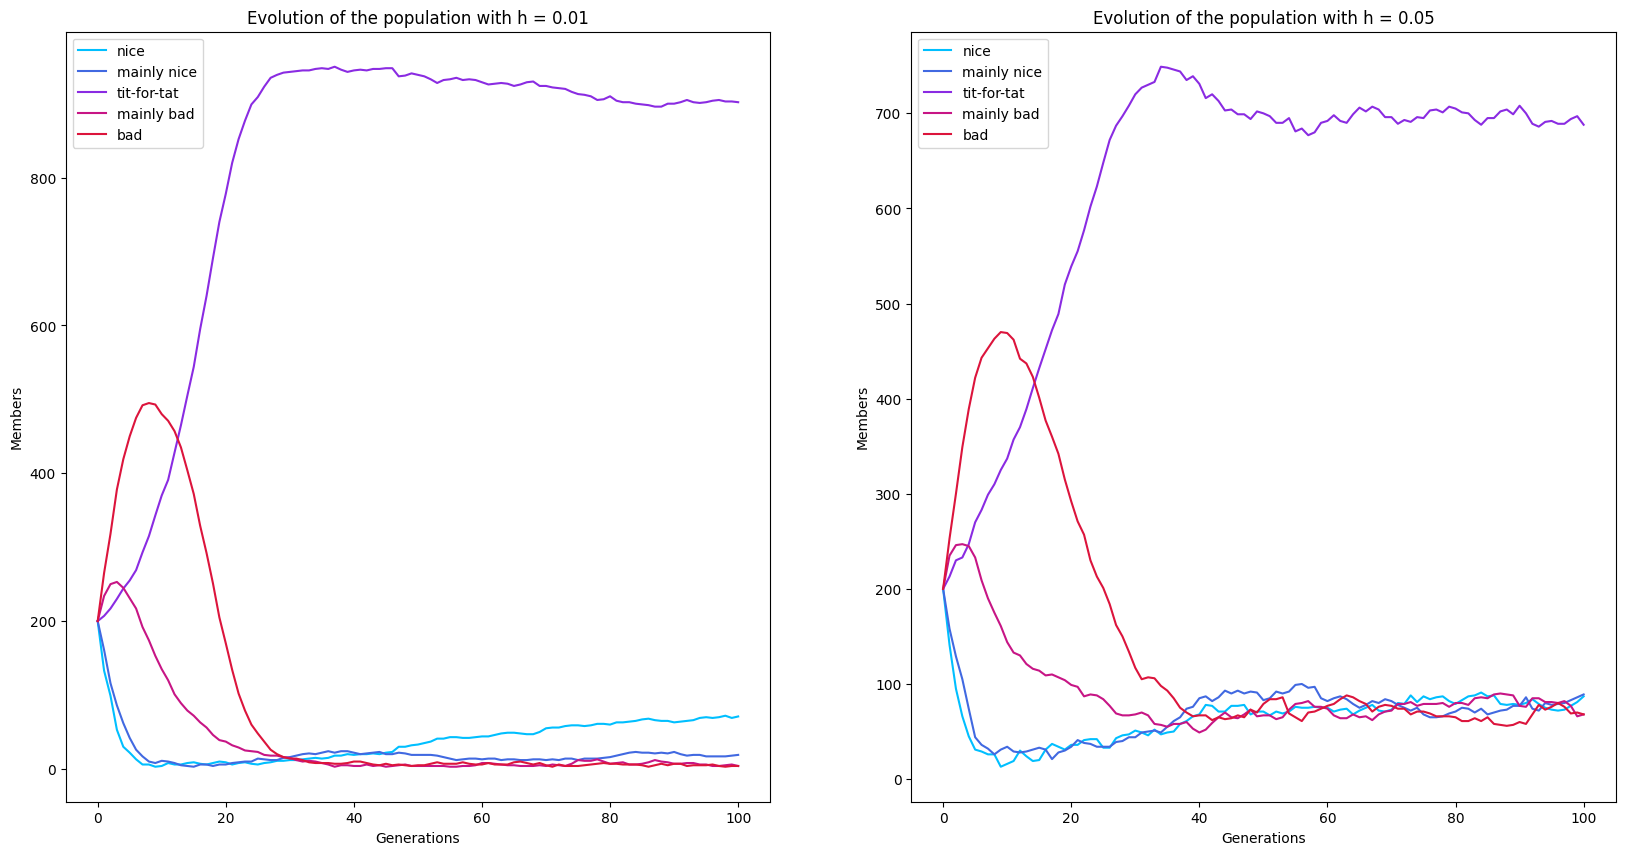

In [148]:
h = 0.01
h1 = 0.05
init = [0.2,0.2,0.2,0.2,0.2]

tot = 1000

nice_pop, bad_pop, m_nice_pop, m_bad_pop, tft_pop = Populate(init,tot,genes,k)

rounds = 100
matches = 50

nice_pop_evol, bad_pop_evol, m_nice_pop_evol, m_bad_pop_evol, tft_pop_evol = StartMutating(nice_pop, bad_pop, m_nice_pop, m_bad_pop, tft_pop, M, rounds, matches, genes, k, h, tot)
nice_pop_evol1, bad_pop_evol1, m_nice_pop_evol1, m_bad_pop_evol1, tft_pop_evol1 = StartMutating(nice_pop, bad_pop, m_nice_pop, m_bad_pop, tft_pop, M, rounds, matches, genes, k, h1, tot)

fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize = (20,10))
ax1.plot(np.arange(len(nice_pop_evol)),nice_pop_evol, label='nice', c = "deepskyblue")
ax1.plot(np.arange(len(nice_pop_evol)),m_nice_pop_evol, label='mainly nice', c = "royalblue")
ax1.plot(np.arange(len(nice_pop_evol)),tft_pop_evol, label='tit-for-tat',c = "blueviolet")
ax1.plot(np.arange(len(nice_pop_evol)),m_bad_pop_evol, label='mainly bad', c = "mediumvioletred")
ax1.plot(np.arange(len(nice_pop_evol)),bad_pop_evol, label='bad', c = "crimson")
ax1.legend(loc='best')
ax1.set_title('Evolution of the population with h = %.2f' %h)
ax1.set_xlabel('Generations')
ax1.set_ylabel('Members')


ax2.plot(np.arange(len(nice_pop_evol1)),nice_pop_evol1, label='nice',c = "deepskyblue")
ax2.plot(np.arange(len(nice_pop_evol1)),m_nice_pop_evol1, label='mainly nice', c = "royalblue")
ax2.plot(np.arange(len(nice_pop_evol1)),tft_pop_evol1, label='tit-for-tat', c = "blueviolet")
ax2.plot(np.arange(len(nice_pop_evol1)),m_bad_pop_evol1, label='mainly bad', c = "mediumvioletred")
ax2.plot(np.arange(len(nice_pop_evol1)),bad_pop_evol1, label='bad', c = "crimson")
ax2.legend(loc='best')
ax2.set_title('Evolution of the population with h = %.2f' %h1)
ax2.set_xlabel('Generations')
ax2.set_ylabel('Members')
plt.show()

These graphs shows that the population that survives after mutations is the tft one, as expected. It is also possible to notice that the nice population starts growing slowly and this happens due to the fact that there are no bad guys alive and while playing against tft they don't get penalized. In fact the matches between nice guys and tft can lead only to a draw.

On the other hand it can be noticed that if the value of the h parameter is increased the random aspect predominates.